In [3]:
import numpy as np
import qutip as qt
from scipy.stats import entropy
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca
import qutip as qt
from qutip_qip.operations import cnot, hadamard_transform
import scipy as sc
from time import time 


In [4]:
# SAMLING DM WITH GIVE PURITY

def qt_dm_sampler(pur_min, pur_max):
  rho  = qt.rand_dm(2)
  purity = (rho * rho).tr()
  while purity <= pur_min or purity >= pur_max:
    rho  = qt.rand_dm(2)
    purity = (rho * rho).tr()
  return rho


Eval. time is: % 23.332252740859985


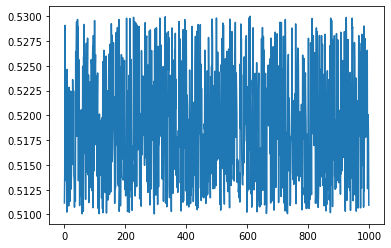

In [5]:
t1 = time()
N_samples = 1000
purity_smapled = np.zeros(N_samples)
qt_given_pur_dmlist = []
for i in range(N_samples):
  res = qt_dm_sampler(0.51,0.53)
  #psi = qt.rand_ket(2)
  #rho = psi * psi.dag()
  purity_smapled[i] = (res * res).tr()
  qt_given_pur_dmlist.append(res.full())
plt.plot(purity_smapled)
t2 = time()

print('Eval. time is: %',t2 - t1)

In [6]:
qt_given_pur_dmarray = np.asarray(qt_given_pur_dmlist)
# np.save(f'/content/gdrive/My Drive/QRC/purity_analysis/sampled_dm', qt_given_pur_dmarray)

In [7]:
# SINGLE QUBIT PAULI basis:
id = qt.identity(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
Pauli_basis = [sx, sy, sz]

def qt_rotationU(theta, ang1,ang2):
  # ang1 \in [0,2 *pi]; ang2 \in [0, npi] -- isomorphism with rotation group.
  nx = np.cos(ang1) * np.sin(ang2)
  ny = np.sin(ang1) * np.sin(ang2)
  nz = np.cos(ang2)
  R_n_theta = np.cos(theta/2) * id  - 1j * np.sin(theta/2) * (nx * sx + ny * sy + nz * sz)
  assert np.abs(np.sqrt(nx**2 + ny**2 + nz**2) - 1) < 10**-12, 'Incorrect parameters encountered'
  return R_n_theta

def rotationU(theta, ang1, ang2):
  # ang1 \in [0,2 *pi]; ang2 \in [0, npi] -- isomorphism with rotation group.
  nx = np.cos(ang1) * np.sin(ang2)
  ny = np.sin(ang1) * np.sin(ang2)
  nz = np.cos(ang2)
  R_n_theta = np.cos(theta/2) * id  - 1j * np.sin(theta/2) * (nx * sx + ny * sy + nz * sz)
  assert np.abs(np.sqrt(nx**2 + ny**2 + nz**2) - 1) < 10**-12, 'Incorrect parameters encountered'
  return R_n_theta

CX_aq = cnot(2,control=0, target=1)
CX_qa = cnot(2,control=1, target=0)
#Ra1 =  qt_rotationU(1.9280115 , 0.20835902, 1.036779 )
#Ra2 =  qt_rotationU(0.7790491 , -0.36486754,  0.37501633)
# EXAMPLE OF APPLICATION:
# Ra1 =  qt_rotationU(np.pi/2, 0.23,0.7)
# Ra2 =  qt_rotationU(np.pi/2, 0.42,0.62)
# Ra1 =  qt_rotationU(2.0124266 , 0.09999759, 0.9992883) # WORKABLE!!
# Ra2 =  qt_rotationU( 4.1866727e+00,  1.0482564e+00, -2.0034707e-09) # WORKABLE!!
#Ra1 =  qt_rotationU(2.4587252 , 0.10373291, 0.84852356)
#Ra2 =  qt_rotationU(4.1866727e+00,  1.0482564e+00, -2.0034707e-09) 
Ra1 =  qt_rotationU(1.8743802 , 0.58214647, 1.0693586)
Ra2 =  qt_rotationU(1.0390323e+00, -3.0513650e-01,  6.9949473e-04) 
Rq =  id
anzatz_unitary = CX_qa * (qt.tensor(Ra2,Rq)) * CX_aq * (qt.tensor(Ra1,Rq))

def qt_purification_channel(state, anztz_unitary):
  state_in = qt.Qobj(state)
  u = qt.Qobj(anzatz_unitary, dims = [[2,2],[2,2]])
  P0 = qt.basis(2,0) * qt.basis(2,0).dag()
  rho_joint = qt.tensor(P0,state_in)
  state_out = (u * rho_joint * u.dag()).ptrace(1)
  purity_out = (state_out * state_out).tr()
  return state_out, purity_out
  
def get_complex_anzatz(alpha, rotations):
    R = []
    for rotation in rotations:
        R.append(rotationU(*rotation))
    inner_unitary = sc.linalg.expm(-1j * sum([alpha[i] * np.kron(Pauli_basis[i], Pauli_basis[i]) for i in range(3)]))
    return qt.Qobj(np.kron(R[0], R[1]) @ inner_unitary @ np.kron(R[2], R[3]), dims=[[2]*2, [2]*2])

def get_gamma(theta1,ang11,ang12, theta2, ang21, ang22):
  # ANZATZ UNITARY:
  Ra1 =  qt_rotationU(theta1,ang11,ang12)
  Ra2 =  qt_rotationU(theta2, ang21, ang22)
  Rq =  id
  u = CX_qa * (qt.tensor(Ra2,Rq)) * CX_aq * (qt.tensor(Ra1,Rq))
  Pauli_basis = [sx,sy,sz]
  P0 = qt.basis(2,0) * qt.basis(2,0).dag()
  gamma = np.zeros((3,3))
  s0 = np.zeros(3)
  for i in range(len(Pauli_basis)):
    id_dilated = qt.tensor(P0,Pauli_basis[i])
    s0[i] = ((1/2) * Pauli_basis[i] * (u * id_dilated * u.dag()).ptrace(1)).tr()
    for j in range(len(Pauli_basis)):
      sigma_dilated = qt.tensor(P0,Pauli_basis[i])
      gamma[i,j] = ((1/2) * Pauli_basis[j] * (u * sigma_dilated * u.dag()).ptrace(1)).tr()
  
  return gamma,s0

def get_gamma_complex(alpha, rotations):

  # ANZATZ UNITARY:
  u  = get_complex_anzatz(alpha, rotations)
  Pauli_basis = [sx,sy,sz]
  P0 = qt.basis(2,0) * qt.basis(2,0).dag()
  gamma = np.zeros((3,3))
  s0 = np.zeros(3)
  for i in range(len(Pauli_basis)):
    id_dilated = qt.tensor(P0,Pauli_basis[i])
    s0[i] = ((1/2) * Pauli_basis[i] * (u * id_dilated * u.dag()).ptrace(1)).tr()
    for j in range(len(Pauli_basis)):
      sigma_dilated = qt.tensor(P0,Pauli_basis[i])
      gamma[i,j] = ((1/2) * Pauli_basis[j] * (u * sigma_dilated * u.dag()).ptrace(1)).tr()
  
  return gamma,s0


In [8]:
alpha = [0.4406405 , 1.1309928 , 0.44251928]
rotations = [
         [1.5706338 , 0.25005922, 0.7473237 ],
         [3.1415927 , 0.20195979, 0.7275571 ],
         [1.4890401, 0.3383612, 0.662342 ],
         [1.0503925, 0.2508376, 0.7540839],
        ]
anzatz_unitary = get_complex_anzatz(alpha,rotations)

gamma, s0 = get_gamma_complex(alpha, rotations)
gamma,s0

(array([[ 0.00072296, -0.49722724, -0.00167308],
        [-0.59240472,  0.10574722,  0.15975807],
        [-0.04995558,  0.20490018, -0.54104849]]),
 array([ 0.00072296,  0.10574722, -0.54104849]))

In [9]:
# Testing a particular Anzatz:
anzatz_u = anzatz_unitary.full()
purity_delta_results = np.zeros(1000)
purity_results = np.zeros(1000)
purity_in =  np.zeros(1000)
fidelity = np.zeros(1000)
state_list  = []
for i in range(len(qt_given_pur_dmarray)):
  rho_test = qt_given_pur_dmarray[i]
  purity_input = np.real(np.trace(rho_test @ rho_test))
  state_out, purity_out = qt_purification_channel(rho_test,anzatz_u)
  state_list.append(state_out)
  purity_delta_results[i] = purity_out - purity_input
  purity_results[i] = purity_out
  purity_in[i] = purity_input
  qrho_in = qt.Qobj(rho_test)
  qrho_out = qt.Qobj(state_out)
  fidelity[i]  = qt.fidelity(qrho_in ,qrho_out)

In [10]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

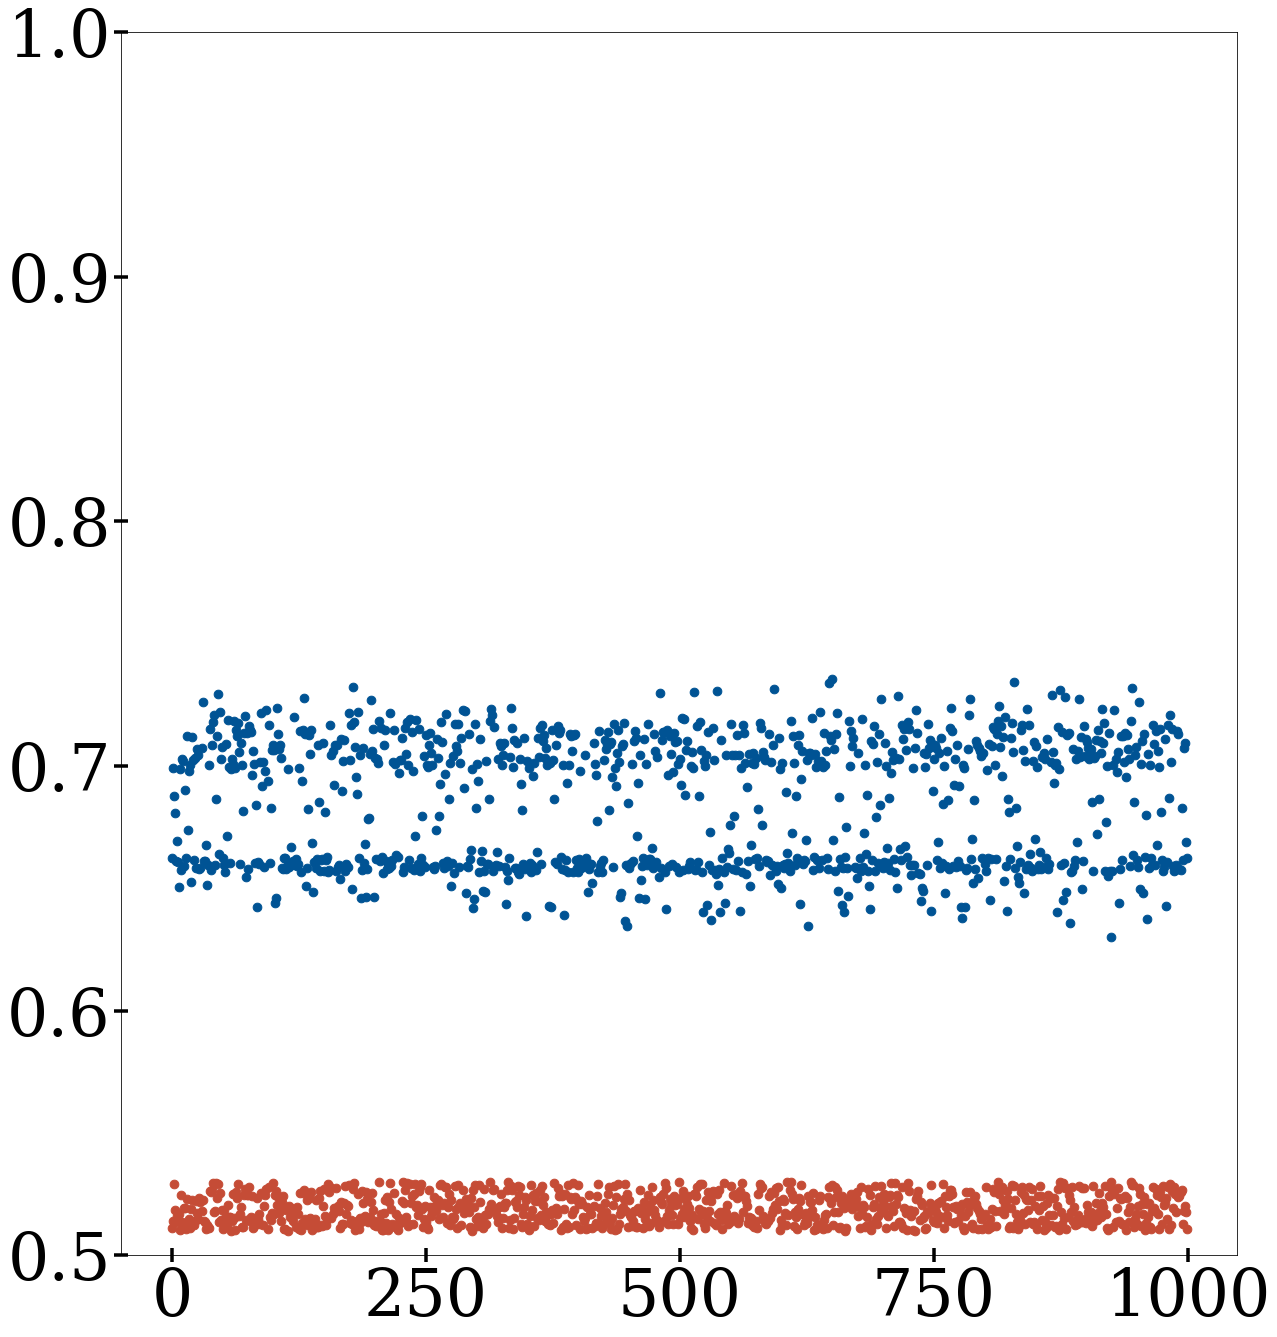

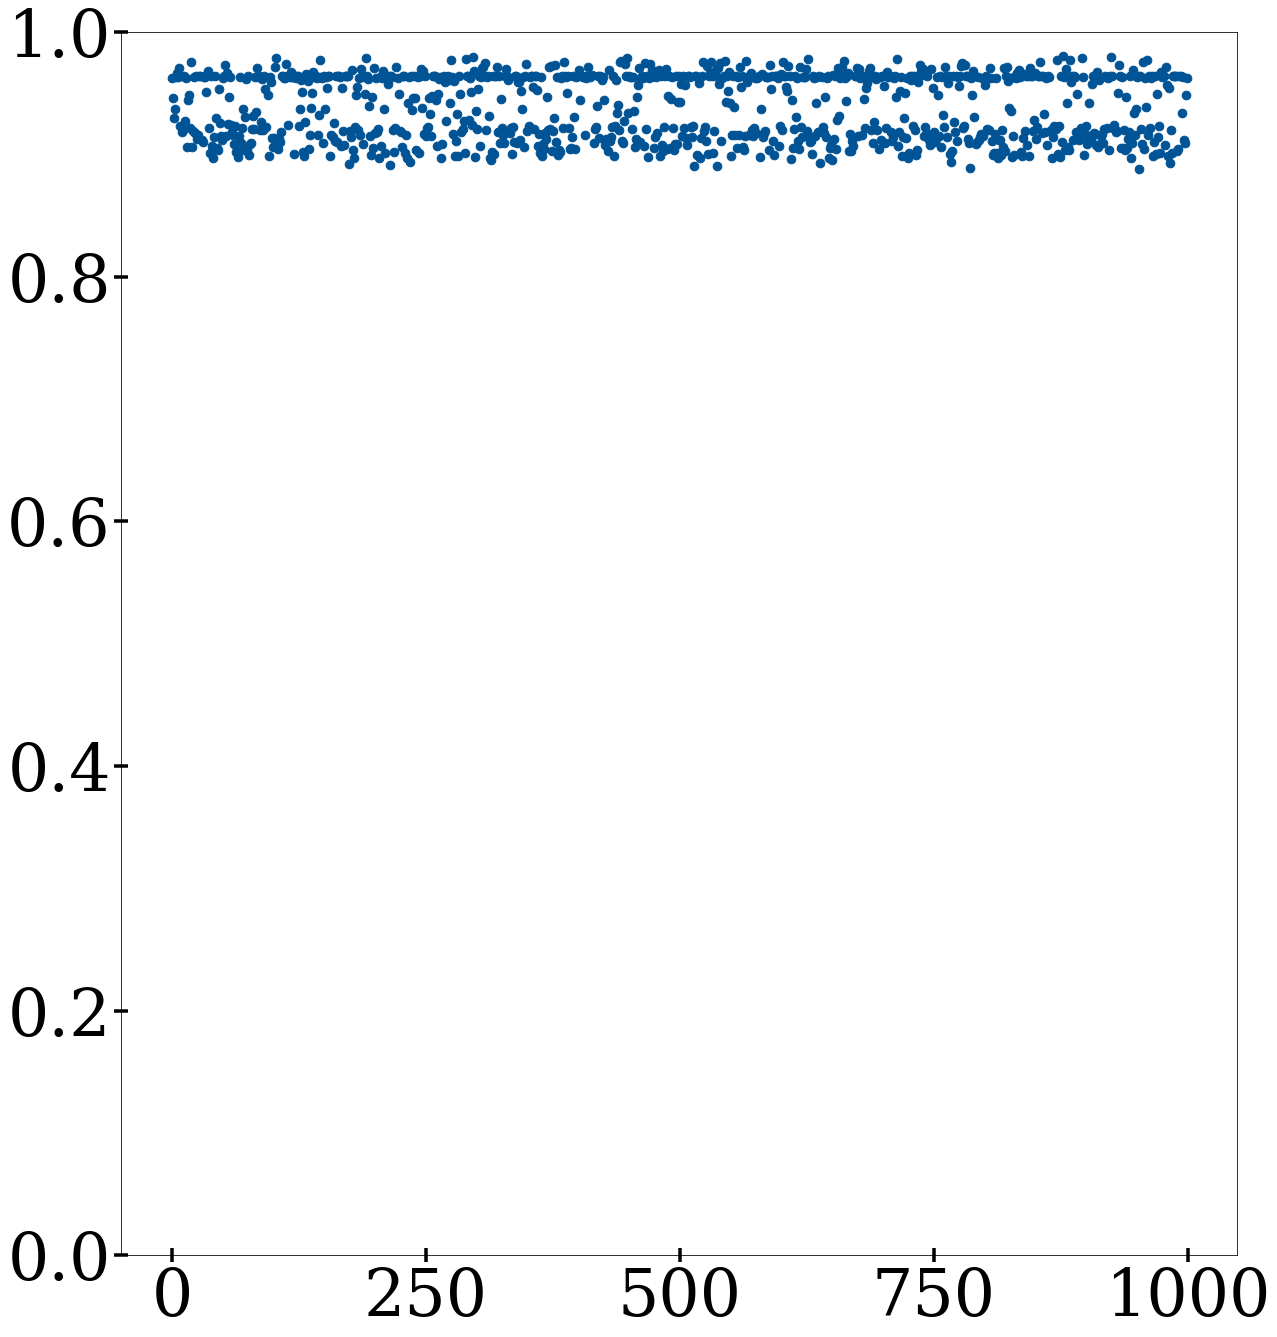

In [15]:
fig1, ax1 = plt.subplots(figsize = (20,22.5))
fig2, ax2 = plt.subplots(figsize = (20,22.5))
font1 = {
        'weight': 'normal',
        'size': 45,
        }
ax1.tick_params(axis='both', which='major', labelsize=65, width = 3.5, length = 14, direction = 'inout')
ax1.set_ylim(0.5, 1.)
# ax[1].tick_params(axis='both', which='major', labelsize=65, width = 3.5, length = 14, direction = 'inout')
# ax[1].set_ylim(0,0.5)
ax2.tick_params(axis='both', which='major', labelsize=65, width = 3.5, length = 14, direction = 'inout')
ax2.set_ylim(0, 1)

ax1.scatter(np.arange(len(purity_results)),purity_results,color = '#005394', s = 75)
ax1.scatter(np.arange(len(purity_in)),purity_in,color = '#C54C36', s = 75)
# ax[1].scatter(np.arange(len(purity_delta_results)),purity_delta_results,color = '#005394')
ax2.scatter(np.arange(len(fidelity)),fidelity,color = '#005394', s = 75)

fig1.savefig(f'../Plots/PURITY.svg', format='svg', dpi=1000)
fig2.savefig(f'../Plots/FIDELITY.svg', format='svg', dpi=1000)

In [16]:
def get_gamma(theta1,ang11,ang12, theta2, ang21, ang22):
  # ANZATZ UNITARY:
  Ra1 =  qt_rotationU(theta1,ang11,ang12)
  Ra2 =  qt_rotationU(theta2, ang21, ang22)
  Rq =  id
  u = CX_qa * (qt.tensor(Ra2,Rq)) * CX_aq * (qt.tensor(Ra1,Rq))
  Pauli_basis = [sx,sy,sz]
  P0 = qt.basis(2,0) * qt.basis(2,0).dag()
  gamma = np.zeros((3,3))
  for i in range(len(Pauli_basis)):
    for j in range(len(Pauli_basis)):
      sigma_dilated = qt.tensor(P0,Pauli_basis[i])
      gamma[i,j] = (Pauli_basis[j] * (u * sigma_dilated * u.dag()).ptrace(1)).tr()
  return gamma
  

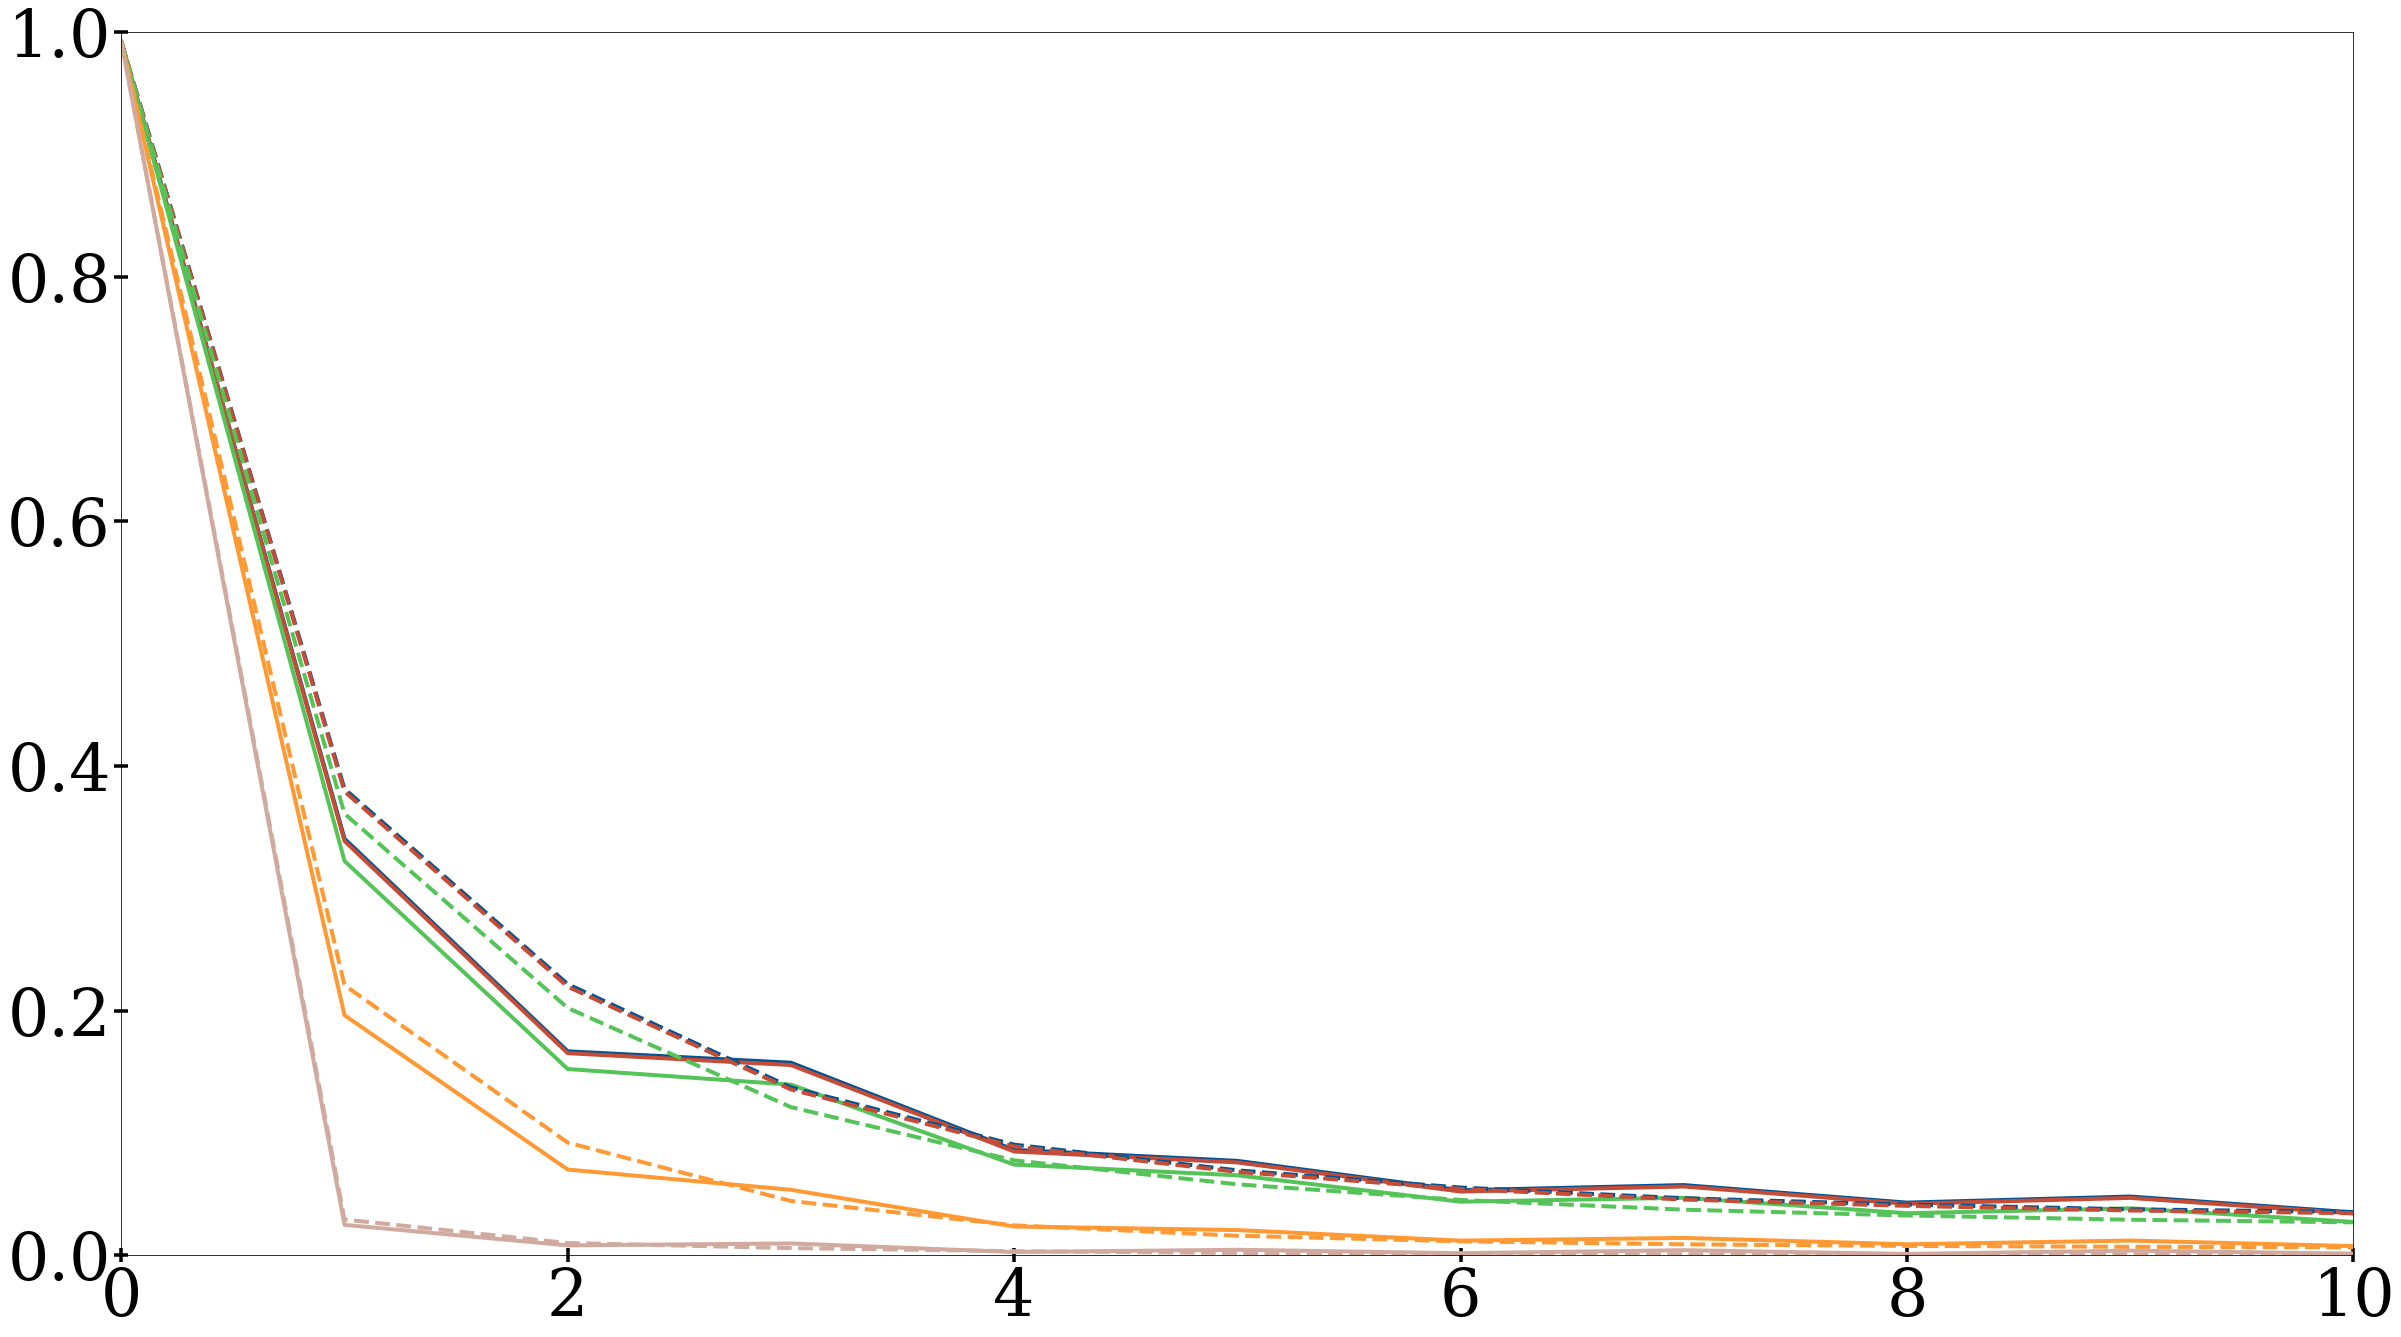

In [ ]:
fig1, ax1 = plt.subplots(1, figsize = (40,22.5))
font1 = {
        'weight': 'normal',
        'size': 45,
        }
ax1.tick_params(axis='both', which='major', labelsize=65, width = 3.5, length = 14, direction = 'inout')
ax1.set_ylim(0,1)
ax1.set_xlim(0,10)
p = [0,0.001,0.01,0.1,0.5]
purity_off = []
purity_on = []
PQ_on = []
PQ_off = []
for i in p:
  purity_off.append(np.load(f'/content/gdrive/My Drive/QRC/final/NoPURITY_NQ_({3},{4})_DP_{i}.npy'))
  purity_on.append(np.load(f'/content/gdrive/My Drive/QRC/final/PURITY_NQ_({3},{4})_DP_{i}.npy'))
  PQ_on.append(np.load(f'/content/gdrive/My Drive/QRC/final/PQ_NQ_({3},{4})_DP_{i}.npy'))
  PQ_off.append(np.load(f'/content/gdrive/My Drive/QRC/final/NoPQ_NQ_({3},{4})_DP_{i}.npy'))


ax1.plot(np.real(purity_on[0]) - 1/2**7, label = 'PON: 0', linewidth = 4, color = '#005394')
ax1.plot(np.real(purity_on[1])- 1/2**7, label = 'PON: 0.001', linewidth = 4, color = '#C54C36')
ax1.plot(np.real(purity_on[2])- 1/2**7, label = 'PON: 0.01', linewidth = 4, color = '#55C458')
ax1.plot(np.real(purity_on[3])- 1/2**7, label = 'PON: 0.1', linewidth = 4, color = '#FF9933')
ax1.plot(np.real(purity_on[4])- 1/2**7, label = 'PON: 0.5', linewidth = 4, color = '#D1AA9F')

ax1.plot(np.real(purity_off[0])- 1/2**7, label = 'POFF: 0', linewidth = 4, color = '#005394', linestyle = '--')
ax1.plot(np.real(purity_off[1])- 1/2**7, label = 'POFF: 0.001', linewidth = 4, color = '#C54C36', linestyle = '--')
ax1.plot(np.real(purity_off[2])- 1/2**7, label = 'POFF: 0.01', linewidth = 4, color = '#55C458', linestyle = '--')
ax1.plot(np.real(purity_off[3])- 1/2**7, label = 'POFF: 0.1', linewidth = 4, color = '#FF9933', linestyle = '--')
ax1.plot(np.real(purity_off[4])- 1/2**7, label = 'POFF: 0.5', linewidth = 4, color = '#D1AA9F', linestyle = '--')

#ax1.legend(loc = 'center right', prop = font1, frameon = False, bbox_to_anchor = (1.49, 0.6))
fig1.savefig(f'../Plots/RESERVOIR_PURITY_START.svg', format='svg', dpi=1000)

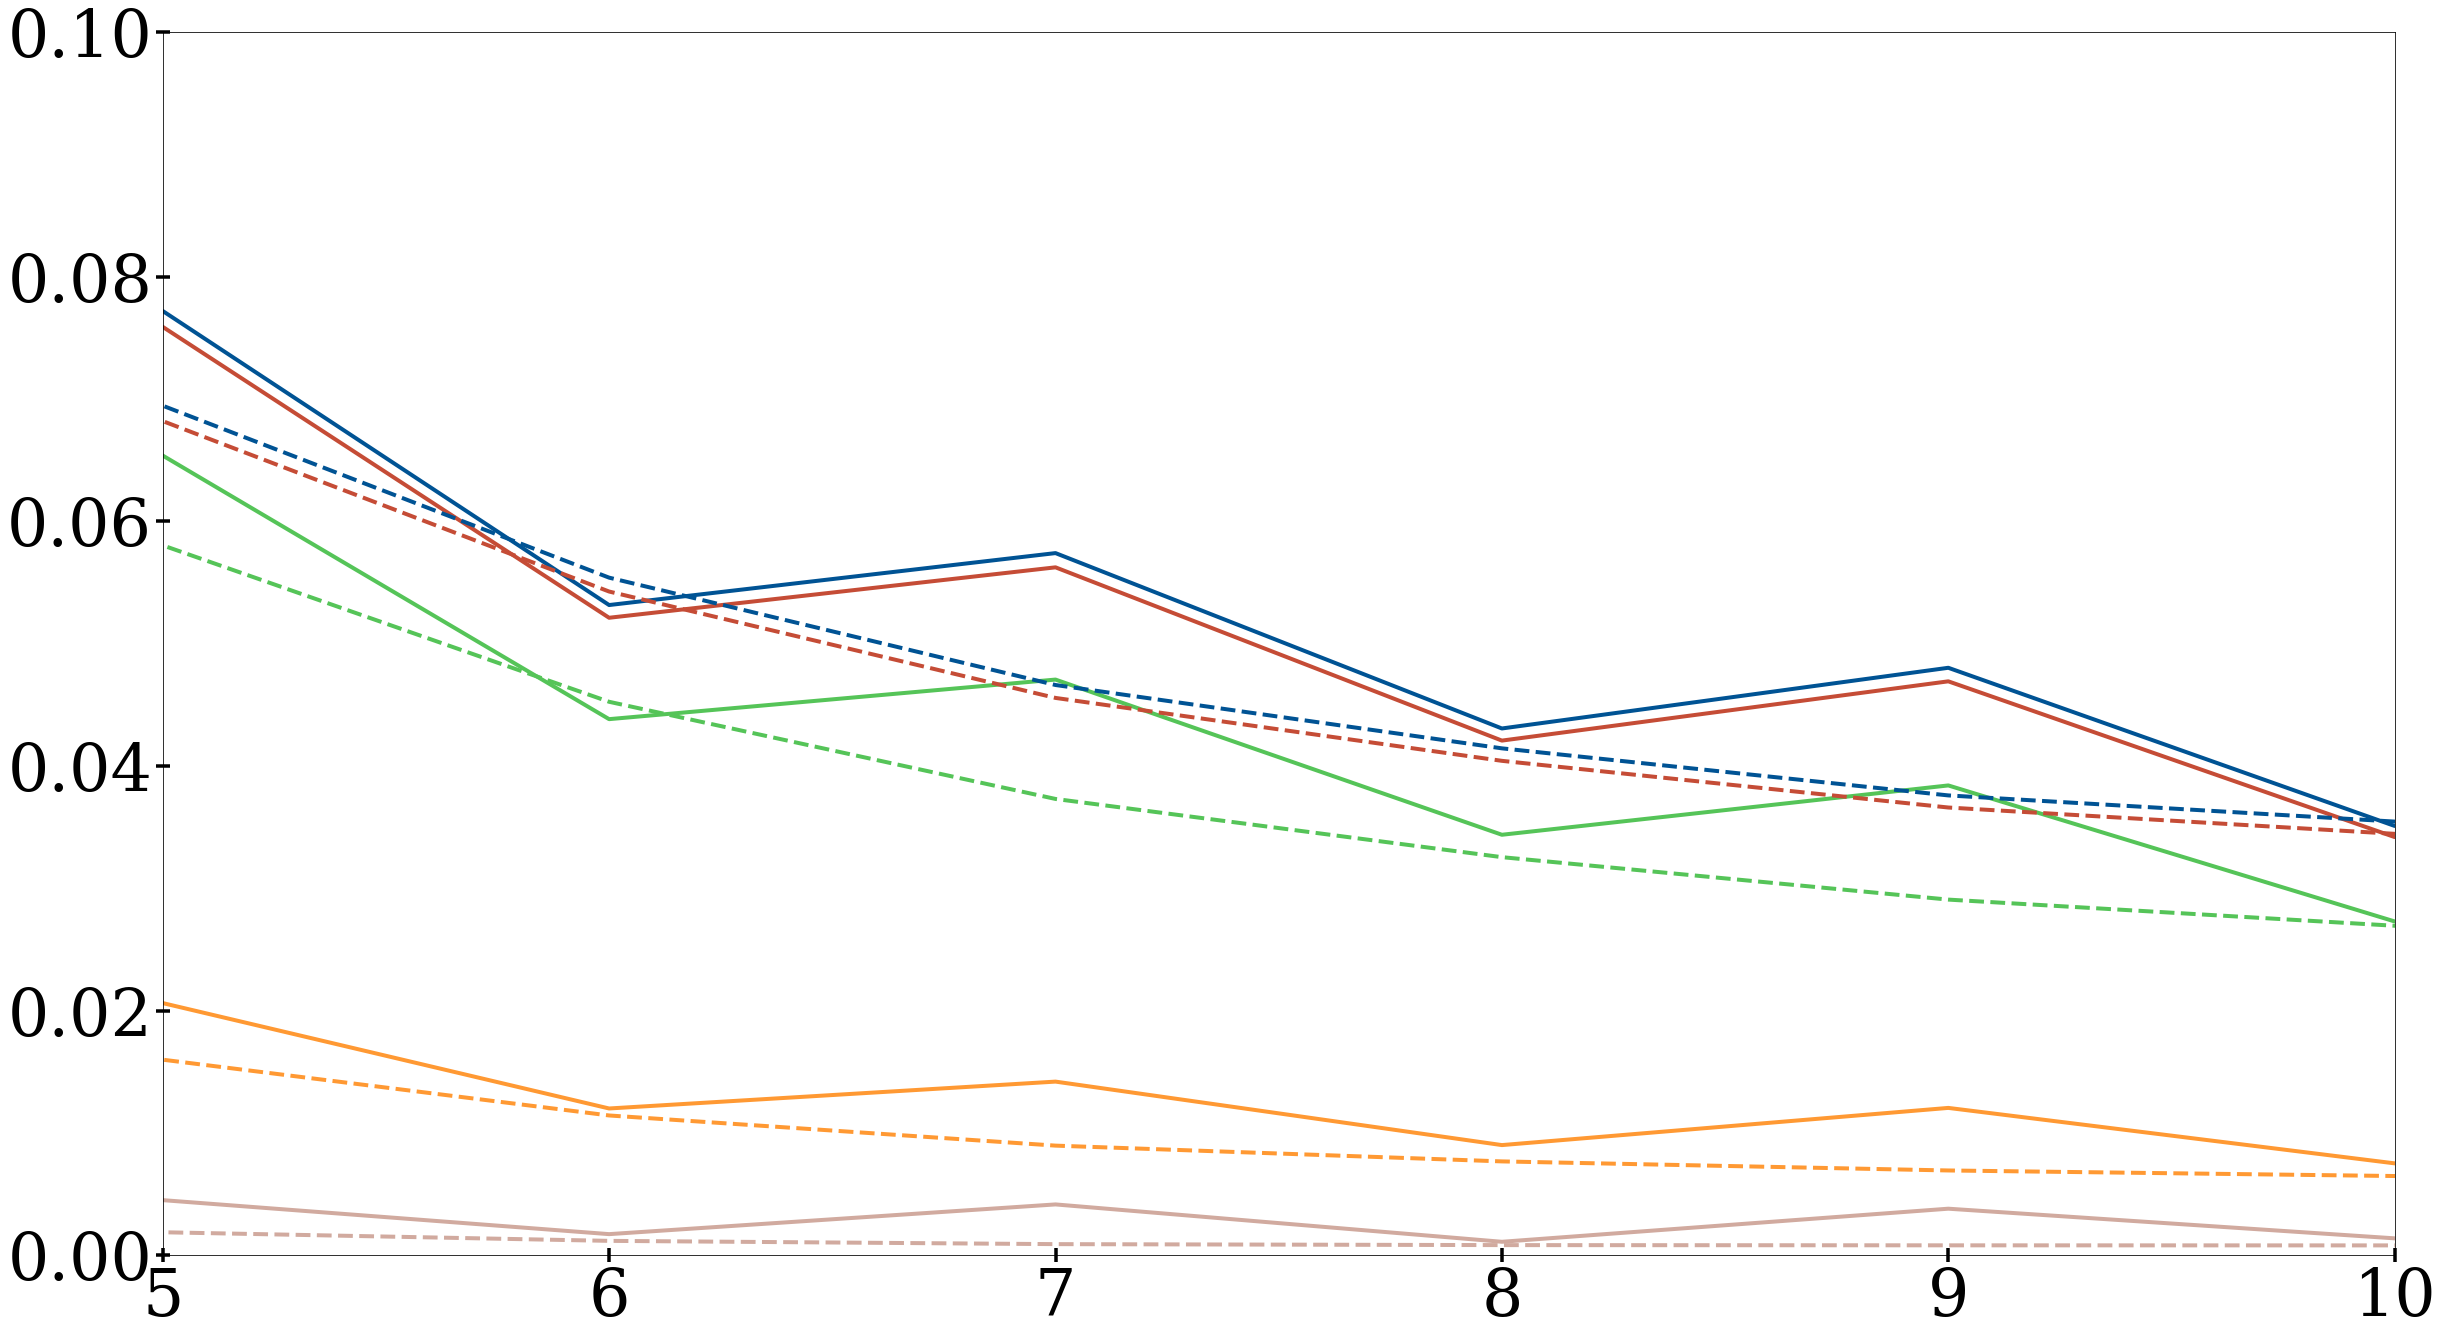

In [18]:
fig1, ax1 = plt.subplots(1, figsize = (40,22.5))
font1 = {
        'weight': 'normal',
        'size': 45,
        }
ax1.tick_params(axis='both', which='major', labelsize=65, width = 3.5, length = 14, direction = 'inout')
ax1.set_ylim(0,0.1)
ax1.set_xlim(5,10)
p = [0,0.001,0.01,0.1,0.5]
purity_off = []
purity_on = []
PQ_on = []
PQ_off = []
for i in p:
  purity_off.append(np.load(f'/content/gdrive/My Drive/QRC/final/NoPURITY_NQ_({3},{4})_DP_{i}.npy'))
  purity_on.append(np.load(f'/content/gdrive/My Drive/QRC/final/PURITY_NQ_({3},{4})_DP_{i}.npy'))
  PQ_on.append(np.load(f'/content/gdrive/My Drive/QRC/final/PQ_NQ_({3},{4})_DP_{i}.npy'))
  PQ_off.append(np.load(f'/content/gdrive/My Drive/QRC/final/NoPQ_NQ_({3},{4})_DP_{i}.npy'))


ax1.plot(np.real(purity_on[0]) - 1/2**7, label = 'PON: 0', linewidth = 4, color = '#005394')
ax1.plot(np.real(purity_on[1])- 1/2**7, label = 'PON: 0.001', linewidth = 4, color = '#C54C36')
ax1.plot(np.real(purity_on[2])- 1/2**7, label = 'PON: 0.01', linewidth = 4, color = '#55C458')
ax1.plot(np.real(purity_on[3])- 1/2**7, label = 'PON: 0.1', linewidth = 4, color = '#FF9933')
ax1.plot(np.real(purity_on[4])- 1/2**7, label = 'PON: 0.5', linewidth = 4, color = '#D1AA9F')

ax1.plot(np.real(purity_off[0])- 1/2**7, label = 'POFF: 0', linewidth = 4, color = '#005394', linestyle = '--')
ax1.plot(np.real(purity_off[1])- 1/2**7, label = 'POFF: 0.001', linewidth = 4, color = '#C54C36', linestyle = '--')
ax1.plot(np.real(purity_off[2])- 1/2**7, label = 'POFF: 0.01', linewidth = 4, color = '#55C458', linestyle = '--')
ax1.plot(np.real(purity_off[3])- 1/2**7, label = 'POFF: 0.1', linewidth = 4, color = '#FF9933', linestyle = '--')
ax1.plot(np.real(purity_off[4])- 1/2**7, label = 'POFF: 0.5', linewidth = 4, color = '#D1AA9F', linestyle = '--')

#ax1.legend(loc = 'center right', prop = font1, frameon = False, bbox_to_anchor = (1.49, 0.6))
fig1.savefig(f'../Plots/RESERVOIR_PURITY_ZOOM.svg', format='svg', dpi=1000)

In [ ]:
PQ_on[0][:,2].shape

(200,)

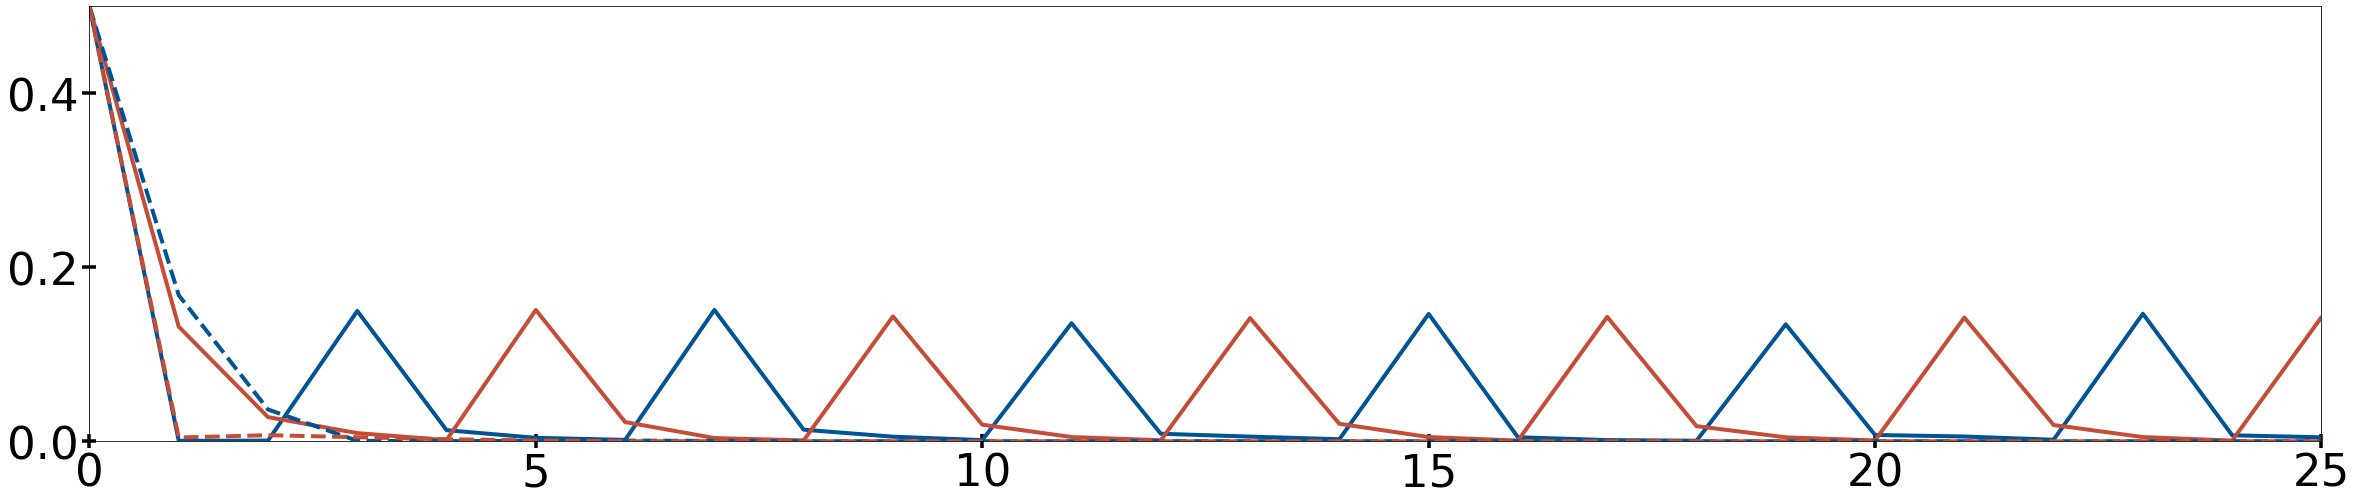

In [ ]:
fig1, ax1 = plt.subplots(1, figsize = (40,8))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=25)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 45,
        }
ax1.tick_params(axis='both', which='major', labelsize=45, width = 3.5, length = 14, direction = 'inout')
ax1.set_ylim(0,1/2)
ax1.set_xlim(0,25)

ax1.plot(np.real(PQ_on[0][:,2]) - 1/2, label = 'PON: A3', linewidth = 4, color = '#005394')
ax1.plot(np.real(PQ_on[0][:,3])- 1/2, label = 'PON:  B1', linewidth = 4, color = '#C54C36')
#ax1.plot(np.real(PQ_on[2][:,2])- 1/2, label = 'PON: 0.01', linewidth = 4, color = '#55C458')
#ax1.plot(np.real(PQ_on[3][:,2])- 1/2, label = 'PON: 0.1', linewidth = 4, color = '#FF9933')
#ax1.plot(np.real(PQ_on[4][:,2])- 1/2, label = 'PON: 0.5', linewidth = 4, color = '#D1AA9F')

ax1.plot(np.real(PQ_off[0][:,2])- 1/2, label = 'POFF: A3', linewidth = 4, color = '#005394', linestyle = '--')
ax1.plot(np.real(PQ_off[0][:,3])- 1/2, label = 'POFF: B1', linewidth = 4, color = '#C54C36', linestyle = '--')
#ax1.plot(np.real(PQ_off[2][:,2])- 1/2, label = 'POFF: 0.01', linewidth = 4, color = '#55C458', linestyle = '--')
#ax1.plot(np.real(PQ_off[3][:,2])- 1/2, label = 'POFF: 0.1', linewidth = 4, color = '#FF9933', linestyle = '--')
#ax1.plot(np.real(PQ_off[4][:,2])- 1/2, label = 'POFF: 0.5', linewidth = 4, color = '#D1AA9F', linestyle = '--')

#ax1.legend(loc = 'center right', prop = font1, frameon = False, bbox_to_anchor = (1.49, 0.6))
fig1.savefig(f'/content/gdrive/My Drive/QRC/FINAL/P_A3.svg', format='svg', dpi=1000)

In [ ]:
-